In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Data Loading


In [15]:
def load_datasets():
    try:
        bag_df = pd.read_csv('Bag+Level+Data.csv')
        pnr_flight_df = pd.read_csv('PNR+Flight+Level+Data.csv')
        pnr_remark_df = pd.read_csv('PNR Remark Level Data.csv')
        flight_df = pd.read_csv('Flight Level Data.csv')
        airports_df = pd.read_csv('Airports Data.csv')
        print("All data files loaded successfully.")
        return bag_df, pnr_flight_df, pnr_remark_df, flight_df, airports_df
    except FileNotFoundError:
        print("Ensure all CSV files are in the same folder as this notebook.")
        return None, None, None, None, None


Data Cleaning and Merging

In [ ]:

def clean_and_merge(bag_df, pnr_flight_df, pnr_remark_df, flight_df):
    """
    Cleans and merges bag, PNR, SSR, and flight data into a single DataFrame.
    Handles missing columns safely to avoid KeyError.
    """
    import pandas as pd
    import numpy as np

    flight_identifier = ['company_id', 'flight_number', 'scheduled_departure_date_local']

    # Ensure Date Column Exists
    for df in [bag_df, pnr_flight_df, flight_df]:
        if 'scheduled_departure_date_local' not in df.columns and 'scheduled_departure_datetime_local' in df.columns:
            df['scheduled_departure_date_local'] = pd.to_datetime(
                df['scheduled_departure_datetime_local'], errors='coerce'
            ).dt.date.astype(str)

    # Bag Data
    bag_df['bag_type'] = bag_df['bag_type'].astype(str).str.title().str.strip()
    bag_counts = bag_df.groupby(flight_identifier + ['bag_type']).size().unstack(fill_value=0).reset_index()
    for col in ['Origin', 'Transfer']:
        if col not in bag_counts.columns:
            bag_counts[col] = 0

    # PNR Data
    def is_yes(series):
        return series.astype(str).str.strip().str.upper().eq('Y')

    pnr_agg = pnr_flight_df.groupby(flight_identifier + ['record_locator']).agg(
        total_pax=('total_pax', 'first'),
        children_count=('is_child', lambda x: is_yes(x).sum()),
        stroller_users=('is_stroller_user', lambda x: is_yes(x).any()),
        lap_child_count=('lap_child_count', 'max')
    ).reset_index()

    flight_pax_data = pnr_agg.groupby(flight_identifier).agg(
        total_pax=('total_pax', 'sum'),
        children_count=('children_count', 'sum'),
        stroller_users=('stroller_users', 'sum'),
        lap_child_count=('lap_child_count', 'sum')
    ).reset_index()

    # Special Service Request Data
    flight_info_cols = [col for col in flight_identifier + ['record_locator'] if col in pnr_flight_df.columns]
    ssr_merged = pd.merge(pnr_remark_df, pnr_flight_df[flight_info_cols], on='record_locator', how='left')

    for col in flight_identifier:
        if col not in ssr_merged.columns:
            ssr_merged[col] = np.nan

    ssr_flight_counts = ssr_merged.groupby(flight_identifier, dropna=False).size().reset_index(name='ssr_count')

    # flight data
    flight_df['scheduled_departure_datetime_local'] = pd.to_datetime(flight_df['scheduled_departure_datetime_local'], errors='coerce')
    flight_df['actual_departure_datetime_local'] = pd.to_datetime(flight_df['actual_departure_datetime_local'], errors='coerce')
    flight_df.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)

    # merge all
    flight_features = (
        flight_df
        .merge(flight_pax_data, on=flight_identifier, how='left')
        .merge(ssr_flight_counts, on=flight_identifier, how='left')
        .merge(bag_counts, on=flight_identifier, how='left')
    )

    # --- FILL NA WITH 0 ---
    cols_to_fill_zero = ['total_pax', 'children_count', 'stroller_users', 'lap_child_count', 'ssr_count', 'Origin', 'Transfer']
    for col in cols_to_fill_zero:
        if col in flight_features.columns:
            flight_features[col].fillna(0, inplace=True)

    print(" Data cleaning and merging complete.")
    return flight_features



In [17]:
def basic_summary(df):
    print("\n🔹 Basic Dataset Summary:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\nColumns:", list(df.columns))
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nData Types:\n", df.dtypes)

Exploratory Data Analysis

In [18]:
def flight_distribution(df):
    plt.figure(figsize=(8, 5))
    df['total_pax'].plot(kind='hist', bins=20, edgecolor='black')
    plt.title('Distribution of Total Passengers per Flight')
    plt.xlabel('Total Passengers')
    plt.ylabel('Number of Flights')
    plt.grid(True)
    plt.show()

    if 'Origin' in df.columns and 'Transfer' in df.columns:
        plt.figure(figsize=(7, 5))
        df[['Origin', 'Transfer']].sum().plot(kind='bar', color=['skyblue', 'salmon'])
        plt.title('Total Bags by Type (Origin vs Transfer)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

def delay_analysis(df):
    df['scheduled_departure_datetime_local'] = pd.to_datetime(df['scheduled_departure_datetime_local'])
    df['actual_departure_datetime_local'] = pd.to_datetime(df['actual_departure_datetime_local'])
    df['delay_minutes'] = (df['actual_departure_datetime_local'] - df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
    avg_delay = df['delay_minutes'].mean()
    print(f"\nAverage Departure Delay: {avg_delay:.2f} minutes")

    plt.figure(figsize=(8, 5))
    df['delay_minutes'].plot(kind='hist', bins=30, color='lightcoral', edgecolor='black')
    plt.title('Distribution of Flight Departure Delays')
    plt.xlabel('Delay (minutes)')
    plt.ylabel('Number of Flights')
    plt.grid(True)
    plt.show()

def correlation_analysis(df):
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    if numeric_df.empty:
        print("No numeric data available for correlation heatmap.")
        return

    corr = numeric_df.corr()
    print("\nCorrelation Matrix:\n", corr)

    plt.figure(figsize=(10, 8))
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Correlation')
    plt.title('Feature Correlation Heatmap')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout()
    plt.show()

Scoring Module

In [19]:
def create_features(df):
    df = df.copy()
    df['total_bags'] = df.get('Origin', 0) + df.get('Transfer', 0)
    df['transfer_bag_ratio'] = np.where(df['total_bags']>0, df['Transfer']/df['total_bags'], 0)
    df['bags_per_person'] = np.where(df['total_pax']>0, df['total_bags']/df['total_pax'],0)
    df['ssr_per_person'] = np.where(df['total_pax']>0, df['ssr_count']/df['total_pax'],0)
    df['passenger_load_ratio'] = np.where(df['total_seats']>0, (df['total_pax']/df['total_seats']).clip(upper=1.5), 0)
    df['ground_time_pressure'] = np.where(df.get('scheduled_ground_time_minutes',0)>0, 
                                          df.get('minimum_turn_minutes',0)/df.get('scheduled_ground_time_minutes',0),0)
    df.replace([np.inf, -np.inf],0, inplace=True)
    df.fillna(0,inplace=True)
    return df

def normalize_features(df, features):
    for feature in features:
        df[f"{feature}_norm"] = df.groupby('scheduled_departure_date_local')[feature].transform(
            lambda x: (x - x.min())/(x.max()-x.min()) if x.max()>x.min() else 0
        )
    df.fillna(0,inplace=True)
    return df

def calculate_difficulty_score(df):
    df = df.copy()
    features_for_score = ['ground_time_pressure','passenger_load_ratio','transfer_bag_ratio',
                          'bags_per_person','ssr_per_person','children_count','stroller_users']
    df = normalize_features(df, features_for_score)

    weights = {'ground_time_pressure_norm':0.25,'passenger_load_ratio_norm':0.20,
               'transfer_bag_ratio_norm':0.15,'ssr_per_person_norm':0.15,
               'bags_per_person_norm':0.10,'children_count_norm':0.10,'stroller_users_norm':0.05}

    df['difficulty_score'] = sum(df[f]*w for f,w in weights.items())
    df['daily_rank'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(ascending=False, method='dense')
    df['difficulty_class'] = pd.qcut(df['daily_rank'], q=[0,.75,.90,1.], labels=['Easy','Medium','Difficult'], duplicates='drop')
    print("Difficulty scoring completed.")
    return df

def plot_difficult_destinations(df, top_n=10):
    difficult_flights = df[df['difficulty_class']=='Difficult']
    if 'scheduled_arrival_station_code' in df.columns:
        dest_counts = difficult_flights['scheduled_arrival_station_code'].value_counts().nlargest(top_n)
        plt.figure(figsize=(10,6))
        dest_counts.sort_values().plot(kind='barh', color='skyblue')
        plt.title(f'Top {top_n} Most Frequent "Difficult" Destinations')
        plt.xlabel('Number of Difficult Flights')
        plt.ylabel('Destination Airport')
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.show()


Pipeline

All data files loaded successfully.


C:\Users\Mayank Raj\AppData\Local\Temp\ipykernel_2072\1453327766.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flight_features[col].fillna(0, inplace=True)


 Data cleaning and merging complete.

🔹 Basic Dataset Summary:
Rows: 8099, Columns: 23

Columns: ['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local', 'actual_departure_datetime_local', 'actual_arrival_datetime_local', 'total_seats', 'fleet_type', 'carrier', 'scheduled_ground_time_minutes', 'actual_ground_time_minutes', 'minimum_turn_minutes', 'total_pax', 'children_count', 'stroller_users', 'lap_child_count', 'ssr_count', 'Hot Transfer', 'Origin', 'Transfer']

Missing Values:
 company_id                            0
flight_number                         0
scheduled_departure_date_local        0
scheduled_departure_station_code      0
scheduled_arrival_station_code        0
scheduled_departure_datetime_local    0
scheduled_arrival_datetime_local      0
actual_departure_datetime_local       0
actual_arrival_datetime_local         0
t

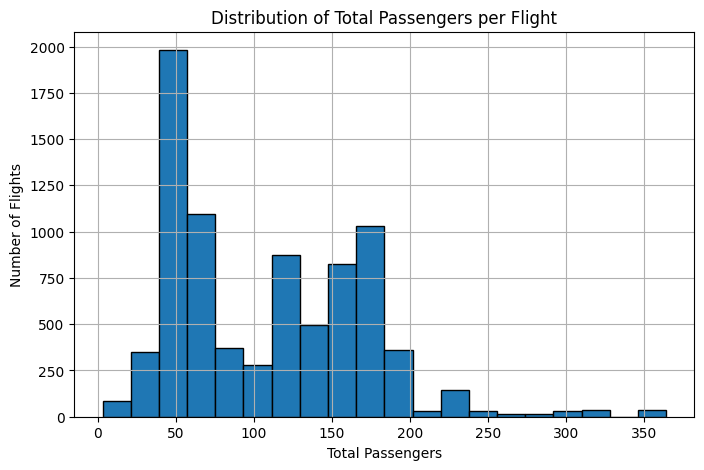

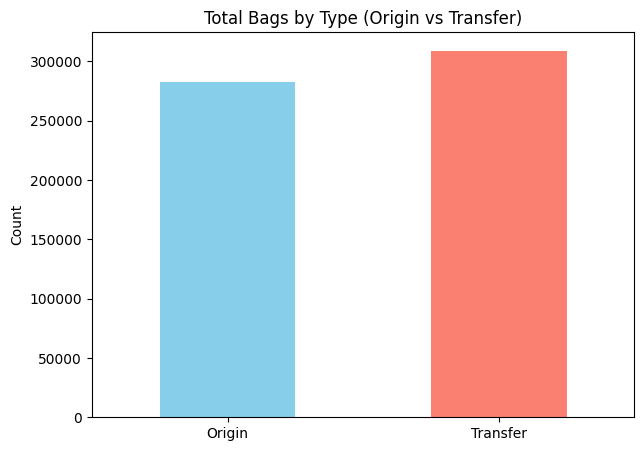


Average Departure Delay: 21.18 minutes


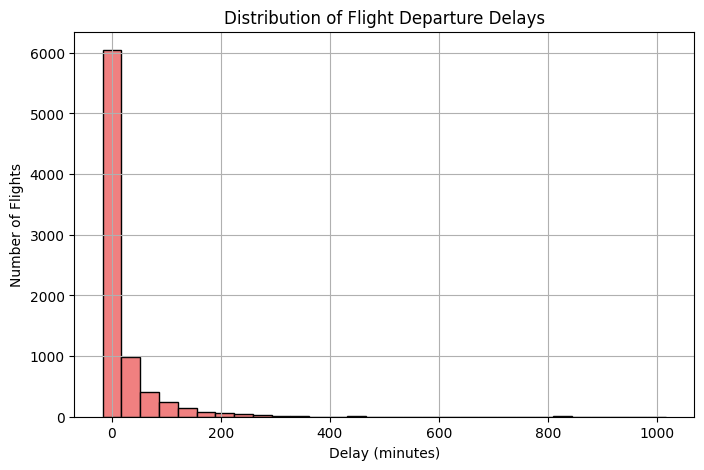


Correlation Matrix:
                                flight_number  total_seats  \
flight_number                       1.000000    -0.817330   
total_seats                        -0.817330     1.000000   
scheduled_ground_time_minutes      -0.074976     0.105679   
actual_ground_time_minutes         -0.078165     0.109170   
minimum_turn_minutes               -0.611087     0.794845   
total_pax                          -0.767280     0.945805   
children_count                     -0.531503     0.681038   
stroller_users                     -0.402678     0.504129   
lap_child_count                    -0.328227     0.393093   
ssr_count                                NaN          NaN   
Hot Transfer                       -0.159656     0.235252   
Origin                             -0.562878     0.751457   
Transfer                           -0.390212     0.523435   
delay_minutes                      -0.011977     0.026573   

                               scheduled_ground_time_minutes  

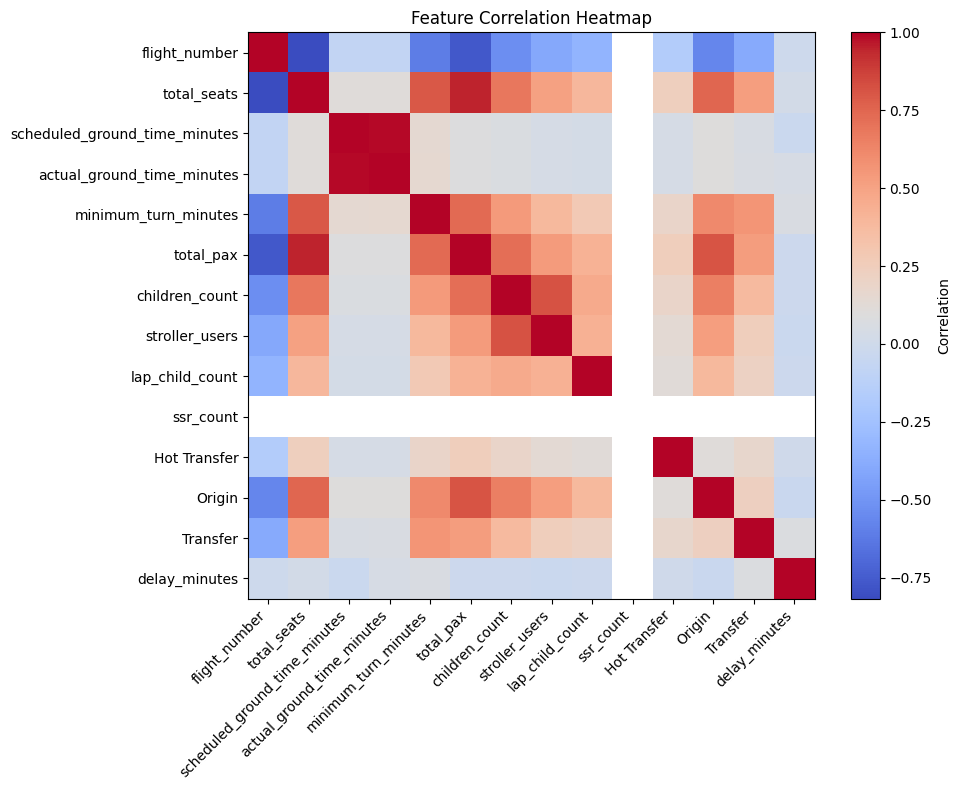

Difficulty scoring completed.


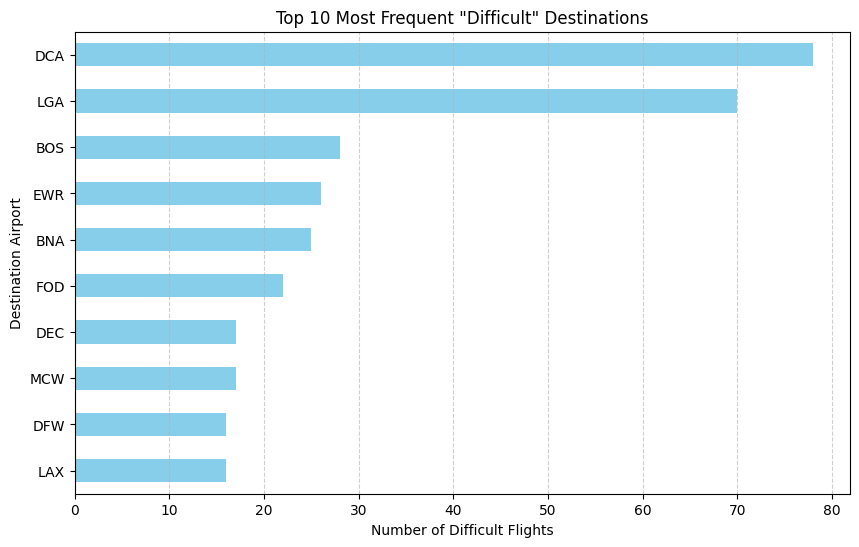

Output CSV saved as 'flight_difficulty_output.csv'


In [20]:
bag_df, pnr_flight_df, pnr_remark_df, flight_df, airports_df = load_datasets()
merged_df = clean_and_merge(bag_df, pnr_flight_df, pnr_remark_df, flight_df)
basic_summary(merged_df)
flight_distribution(merged_df)
delay_analysis(merged_df)
correlation_analysis(merged_df)

merged_df = create_features(merged_df)
scored_df = calculate_difficulty_score(merged_df)
plot_difficult_destinations(scored_df)

# Save CSV
output_cols = ['company_id','flight_number','scheduled_departure_date_local',
               'scheduled_departure_station_code','scheduled_arrival_station_code',
               'difficulty_score','daily_rank','difficulty_class']
scored_df[output_cols].to_csv("flight_difficulty_output.csv", index=False)
print("Output CSV saved as 'flight_difficulty_output.csv'")